# Problem 1.1: Parallel CNNs and RNNs

## 0. Set up

In [ ]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
pip install --upgrade visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 16.7 MB/s eta 0:00:00


In [ ]:
# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import zipfile
import matplotlib.pyplot as plt
import visualkeras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report
import collections

# Deep learning modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LeakyReLU, Concatenate, Dense, Conv1D, MaxPooling1D, LSTM, Dropout, BatchNormalization, Reshape, GRU, Normalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Hyperparameters tuning modules
from kerastuner import HyperParameters
from keras_tuner.tuners import Hyperband


<ipython-input-3-cdd00d1b8de9>:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperParameters


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Data loading and preprocessing

In [ ]:
# Load data from Drive
train_dataset = tf.data.Dataset.load('/content/drive/MyDrive/Colab Notebooks/assign2_train')
val_dataset = tf.data.Dataset.load('/content/drive/MyDrive/Colab Notebooks/assign2_val')

In [ ]:
# Set initial batch size as 128
batch_size = 128
train_dataset_batch = train_dataset.batch(batch_size)
val_dataset_batch = val_dataset.batch(batch_size)

In [ ]:
# Create function to convert a batched tf.data.Dataset into NumPy arrays

def dataset_to_numpy(dataset_batch):
    data_list, label_list = list(), list()

    # Iterate through each batch
    for x_batch, y_batch in dataset_batch:

        # Convert tensors to NumPy arrays and append to lists
        data_list.append(x_batch.numpy())
        label_list.append(y_batch.numpy())

    # Concatenate into single NumPy arrays
    x = np.concatenate(data_list, axis=0)
    y = np.concatenate(label_list, axis=0)

    return x, y

In [ ]:
# Split into training/testing features and labels
data_train, label_train = dataset_to_numpy(train_dataset_batch)
data_val, label_val = dataset_to_numpy(val_dataset_batch)

In [ ]:
# Calculate value range
range = data_train.max() - data_train.min()

# Data normalisation
data_train, data_val = data_train / range, data_val / range

In [ ]:
# Define n_features, n_classes, n_epoch
n_features = data_train.shape[1:]
n_classes = label_train.shape[-1]
n_epoch = 50



---


## 2. Building Parallel Convolutional Neural Network (CNN) models

Here, I implement a shallow parallel CNN architecture to classify music genres, under the condition below:

**[3C8-P4-F] + [4C4-P2-F] → Concatenate → Dense → Output**

- **First Parallel Branch**:
  - 3× Conv2D (8×8 filters)
  - Leaky ReLU (slope = 0.3)
  - MaxPooling2D (4×4)
  - Flatten

- **Second Parallel Branch**:
  - 4× Conv2D (4×4 filters)
  - Leaky ReLU (slope = 0.3)
  - MaxPooling2D (2×2)
  - Flatten

- **Merging Branch**:
  - Concatenate both branches
  - Dense layer for classification (softmax)



---

###Step 1: Determine Best Hyperparameters


**SGD optimisation Methods**
- Hyperparameter Tuning
  1.   Learning Rate
  2.   Momentum
  3.   Nesterov
  4.   Weight Decay
  5.   Clipnorm

- Data Shuffling

**Evaluation Metrics**
- Accuracy

**Loss Function**
- Categorical Crossentropy

---
To optimise a mini-batch stochastic gradient descent algorithm (SGD), hyperparameters are tuned using the **Hyperband** algorithm from Keras Tuner. Unlike standard SGD, using a batch size of 128 can lead to slower convergence and a higher risk of becoming trapped in local minima or saddle points. Moreover, when the loss landscape exhibits sharp gradients in one direction and flatter slopes in another, SGD tends to oscillate along the steeper axis, making overall progress sluggish.

To address this, **momentum** is introduced, tuning how much of the previous gradient (𝑉ₜ) is included to the next step (𝑉ₜ₊₁). Previous gradient information will allow continued movement in the same direction, even at local minimum or saddle points (where the gradient is zero). This can also reduce jitter by smoothing the update direction. Nevertheless, it is common for SGD + momentum to overshoot the minimum due to accumulated momentum. Therefore, **Nesterov Accelerated Gradient (NAG)** is included in the tuning process as a boolean term. This may prevent overshooting by first looking ahead in the direction of the current momentum. Also, the **learning rate** is considered to be the most important hyperparameter in SGD. A rate that is too high can cause the model to overshoot the minimum and diverge, while a rate that is too low can result in slow convergence or getting stuck in plateaus. **Weight Decay (L2 regularization)** and **gradient clipping (clipnorm)** are also included to minimise overfitting and prevent exploding gradients.

Finally, to avoid potential bias from data order when calculating gradients, I randomly shuffle the data before each epoch of training (**shuffle=True**).

In [ ]:
def build_CNN(hp):
    inputs = Input(shape=n_features)

    # First Parallel Branch
    x = Conv2D(3, (8, 8), padding='same')(inputs)
    x = LeakyReLU(negative_slope=0.3)(x)
    x = MaxPooling2D(pool_size=(4, 4))(x)
    x = Flatten()(x)

    # Second Parallel Branch
    y = Conv2D(4, (4, 4), padding='same')(inputs)
    y = LeakyReLU(negative_slope=0.3)(y)
    y = MaxPooling2D(pool_size=(2, 2))(y)
    y = Flatten()(y)

    # Merging Branches
    merged = Concatenate()([x, y])

    # Classification
    outputs = Dense(units=n_classes, activation='softmax')(merged)

    CNN_model = Model(inputs=inputs, outputs=outputs)

    # SGD hyperparameter tuning
    learning_rate = hp.Float('learning_rate', min_value= 1e-5, max_value= 5e-2, step=0.005)
    momentum = hp.Float('momentum', min_value=0.0, max_value=0.9, step=0.1)
    nesterov = hp.Boolean('nesterov')
    weight_decay = hp.Choice('weight_decay', values=[0.0, 1e-6, 1e-5, 1e-4])
    clipnorm = hp.Choice('clipnorm', values=[0.0, 0.25, 5.0, 7.5, 10.0])

    tuned_optimizer = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov, weight_decay=weight_decay, clipnorm=clipnorm)

    CNN_model.compile(optimizer=tuned_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    CNN_model.summary()

    return CNN_model

In [ ]:
tuner = Hyperband(build_CNN, objective='val_accuracy', max_epochs=50, factor=3, directory='tuner_directory', project_name='tune_sgd')

tuner.search(x=data_train, y=label_train, validation_data=(data_val, label_val))

Trial 90 Complete [00h 01m 47s]
val_accuracy: 0.7483333349227905

Best val_accuracy So Far: 0.7483333349227905
Total elapsed time: 00h 41m 10s


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 80, 80, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 80, 80, 3)      │            195 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 80, 80, 4)      │             68 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 80, 80, 3)      │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 80, 80, 4)      │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 20, 20, 3)      │              0 │ leaky_re_lu[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 40, 40, 4)      │              0 │ leaky_re_lu_1[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1200)           │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 6400)           │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 7600)           │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 8)              │         60,808 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 61,071 (238.56 KB)

 Trainable params: 61,071 (238.56 KB)

 Non-trainable params: 0 (0.00 B)

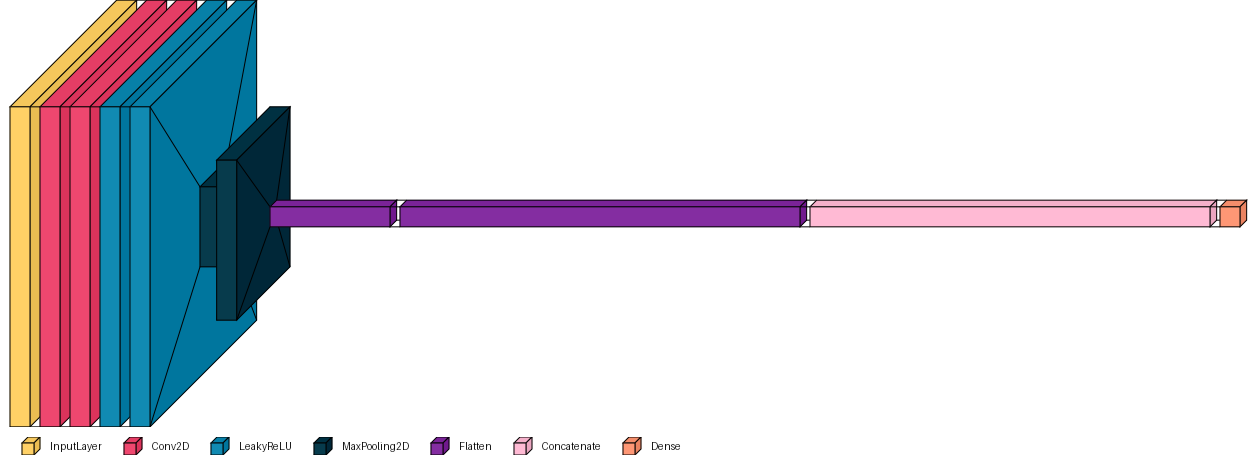

In [ ]:
best_CNN_model = tuner.get_best_models(num_models=1)[0]
visualkeras.layered_view(best_CNN_model, legend=True)



Given set architecture, the best hyperparameters has been chosen as followed:




In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
print("Learning Rate:", best_hp.get('learning_rate'))
print("Momentum:", best_hp.get('momentum'))
print("Nesterov:", best_hp.get('nesterov'))
print("Weight Decay:", best_hp.get('weight_decay'))
print("Clipnorm:", best_hp.get('clipnorm'))

Best hyperparameters:
Learning Rate: 0.04501
Momentum: 0.5
Nesterov: True
Weight Decay: 1e-06
Clipnorm: 7.5


---
###Step 2: Train Parallel CNN with Best Hyperparameters
Based on the selected hyperparameters, 50% of the previous gradient will be incorporated into the next update using Nesterov momentum. A fixed learning rate of 0.04501 is applied. Weight decay (1e-06) applies an L2 penalty to discourage large weights, while gradient clipping (clipnorm = 7.5) will be used to limit the total gradient norm, thus preventing exploding gradients during training.

In [ ]:
# Start training timer
start = time.time()

# Train the model
final_mod1 = build_CNN(best_hp)
history_mod1 = final_mod1.fit(data_train, label_train, epochs=n_epoch, validation_data=(data_val, label_val), shuffle=True)

# End training timer
end = time.time()

# Calculate and print execution time
time_es = (end - start) / 60
print('Minutes to run: ', time_es)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 80, 80, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 80, 80, 3)      │            195 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 80, 80, 4)      │             68 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 80, 80, 3)      │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 80, 80, 4)      │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 20, 20, 3)      │              0 │ leaky_re_lu_2[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 40, 40, 4)      │              0 │ leaky_re_lu_3[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 1200)           │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 6400)           │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 7600)           │              0 │ flatten_2[0][0],       │
│ (Concatenate)             │                        │                │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 8)              │         60,808 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 61,071 (238.56 KB)

 Trainable params: 61,071 (238.56 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4529 - loss: 1.4759 - val_accuracy: 0.5983 - val_loss: 1.1159
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6298 - loss: 1.0184 - val_accuracy: 0.6804 - val_loss: 0.9144
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6935 - loss: 0.8319 - val_accuracy: 0.6900 - val_loss: 0.8649
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7390 - loss: 0.7155 - val_accuracy: 0.7146 - val_loss: 0.8104
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7773 - loss: 0.6288 - val_accuracy: 0.7000 - val_loss: 0.8260
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7920 - loss: 0.5741 - val_accuracy: 0.7233 - val_loss: 0.7909
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8066 - loss: 0.5370 - val_accuracy: 0.7254 - val_loss: 0.7768
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8187 - loss: 0.5009 - val_accuracy: 0.

Text(0.5, 1.0, 'Comparison of Training and Validation Accuracy & Loss')

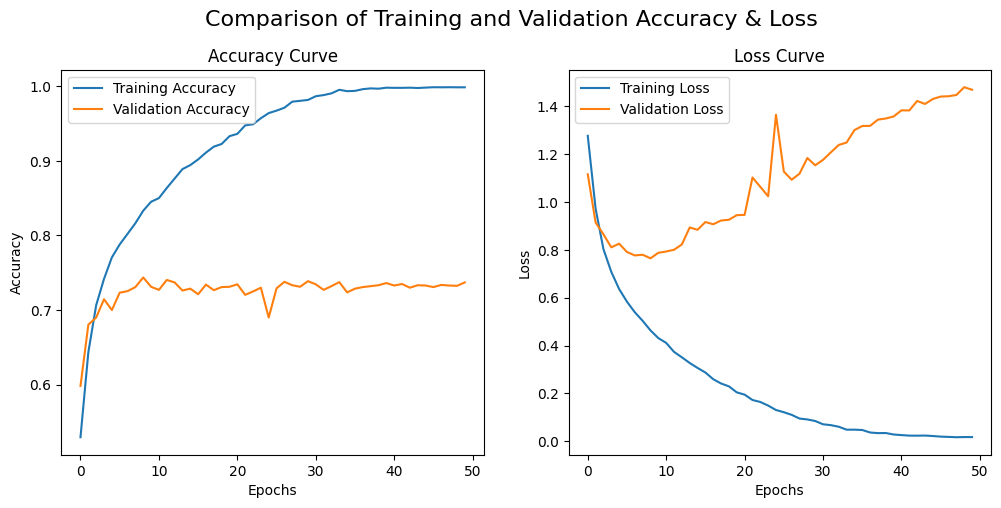

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(history_mod1.history['accuracy'], label='Training Accuracy')
ax1.plot(history_mod1.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title("Accuracy Curve")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend()

# Plot loss
ax2.plot(history_mod1.history['loss'], label='Training Loss')
ax2.plot(history_mod1.history['val_loss'], label='Validation Loss')
ax2.set_title("Loss Curve")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()

fig.suptitle("Comparison of Training and Validation Accuracy & Loss", fontsize=16, y=1.00)

The training accuracy steadily increases, reaching approximately 99% by the 50th epoch, while the validation accuracy plateaus at around **73%**. Moreover, the validation loss begins to drastically rise until 1.47, even if the training loss continues to decrease. This implies that model also fits to the noise of training set, rather than learning generalised patterns, indicating **overfitting**. It is possible that the large dense layer after concatenation (e.g., 19K+ units → 10 classes) has excessive parameters, enabling memorisation of training noise. To address this, the model in P2 will use regularisation techiques (e.g., dropout, L2, batch normalisation).

# Problem 1.2 : Parallel CNNs and RNNs

## 1. Data preprocessing

In [ ]:
# Create a function to reduce the dimension
def reduce_dimension(x, y):

  return tf.squeeze(x, axis=-1), y

train_dataset_squeeze = train_dataset.map(reduce_dimension)
val_dataset_squeeze = val_dataset.map(reduce_dimension)

In [ ]:
# Set initial batch size as 128
batch_size = 128
train_dataset_squeeze_batch = train_dataset_squeeze.batch(batch_size)
val_dataset_squeeze_batch = val_dataset_squeeze.batch(batch_size)

In [ ]:
# Split into training/testing features and labels
data_train_squeeze, label_train_squeeze = dataset_to_numpy(train_dataset_squeeze_batch)
data_val_squeeze, label_val_squeeze = dataset_to_numpy(val_dataset_squeeze_batch)

# Calculate value range
min_val = data_train_squeeze.min()
max_val = data_train_squeeze.max()
value_range = max_val - min_val

# Normalise the data and add small number to prevent division by zero
data_train_squeeze = (data_train_squeeze - min_val) / (value_range + 1e-8)
data_val_squeeze = (data_val_squeeze - min_val) / (value_range + 1e-8)

In [ ]:
n_features_squeeze = data_train_squeeze.shape[1:]

## 2. Building a CNN-RNN Model
Here, I build a CNN-RNN model to classify music genres using Mel spectrograms, with the following layers:

**C4-P2 → C3-P2 → LSTM(128) → LSTM(32) → Dense(200) → Dense(Output)**


###Step 1: Determine Best Hyperparameters


---

**SGD optimisation Methods**
- Hyperparameter Tuning
  1.   Learning Rate
  2.   Momentum
  3.   Nesterov
  4.   Weight Decay
  5.   Clipnorm

- Data Shuffling

**Evaluation Metrics**
- Accuracy

**Loss Function**
- Categorical Crossentropy

---

Likewise, SGD is tuned using the **Hyperband** algorithm from Keras Tuner.
Given the different architecture in p1.2, where an LSTM layer is added after the CNN, the optimal hyperparameters may differ. **Learning rate, momentum, Nesterov, weight decay**, and **clipnorm** are included in the tuning process to address several limitations of SGD discussed earlier. To efficiently pass data from the CNN to the LSTM, I apply **Conv1D** on the input shaped as (80, 80). After convolution and pooling layers, the output has a shape of (18, 6), which is directly compatible with the LSTM layer, eliminating the need for manual reshaping. For classification,  softmax is applied in the dense layer to produce probability distributions.


In [ ]:
def build_CNN_LSTM():
    model_CNN_LSTM = Sequential()

    # First Conv1D
    model_CNN_LSTM.add(Conv1D(8, kernel_size=4, activation='relu', input_shape=n_features_squeeze))
    model_CNN_LSTM.add(MaxPooling1D(pool_size=2))

    # Second Conv1D
    model_CNN_LSTM.add(Conv1D(6, kernel_size=3, activation='relu'))
    model_CNN_LSTM.add(MaxPooling1D(pool_size=2))

    # LSTM layers
    model_CNN_LSTM.add(LSTM(128, return_sequences=True))
    model_CNN_LSTM.add(LSTM(32))

    # Dense layers
    model_CNN_LSTM.add(Dense(200, activation='relu'))
    model_CNN_LSTM.add(Dropout(0.2))
    model_CNN_LSTM.add(Dense(n_classes, activation='softmax'))


    optimizer = SGD(learning_rate=0.01)

    model_CNN_LSTM.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model_CNN_LSTM

model = build_CNN_LSTM()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 77, 8)               │           2,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 38, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 36, 6)               │             150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 18, 6)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 18, 128)             │          69,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 200)                 │           6,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,608 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,654 (393.18 KB)

 Trainable params: 100,654 (393.18 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_CNN_LSTM(hp):
    model_CNN_LSTM = Sequential()

    # First Conv1D
    model_CNN_LSTM.add(Conv1D(8, kernel_size=4, activation='relu', input_shape=n_features_squeeze))
    model_CNN_LSTM.add(MaxPooling1D(pool_size=2))

    # Second Conv1D
    model_CNN_LSTM.add(Conv1D(6, kernel_size=3, activation='relu'))
    model_CNN_LSTM.add(MaxPooling1D(pool_size=2))

    # LSTM layers
    model_CNN_LSTM.add(LSTM(128, return_sequences=True))
    model_CNN_LSTM.add(LSTM(32))

    # Dense layers
    model_CNN_LSTM.add(Dense(200, activation='relu'))
    model_CNN_LSTM.add(Dropout(0.2))
    model_CNN_LSTM.add(Dense(n_classes, activation='softmax'))

    # Tune SGD parameters
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    momentum = hp.Float('momentum', min_value=0.0, max_value=0.9, step=0.1)
    weight_decay = hp.Float('weight_decay', min_value=0.0, max_value=1e-2, step=1e-4)
    clipnorm = hp.Float('clipnorm', min_value=0.1, max_value=10.0, step=1.0)
    nesterov = hp.Boolean('nesterov')

    optimizer = SGD(learning_rate=lr, momentum=momentum, nesterov=nesterov, weight_decay=weight_decay, clipnorm=clipnorm)

    model_CNN_LSTM.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model_CNN_LSTM

In [ ]:
tuner = Hyperband(build_CNN_LSTM, objective='val_accuracy', max_epochs=50, factor=3, directory='my_directory', project_name='cnn_lstm_tuning')

# Run the search
tuner.search(data_train_squeeze, label_train_squeeze, epochs=30, validation_data=(data_val_squeeze, label_val_squeeze))


Trial 90 Complete [00h 03m 12s]
val_accuracy: 0.3883333206176758

Best val_accuracy So Far: 0.5462499856948853
Total elapsed time: 01h 10m 16s


/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


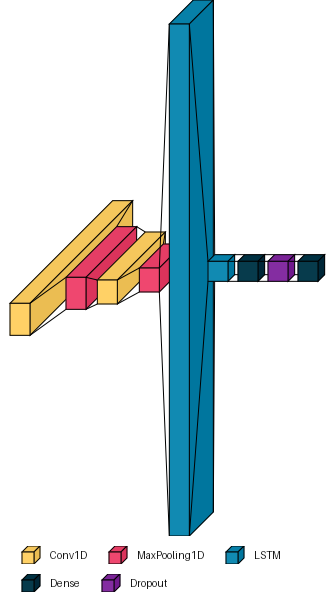

In [ ]:
best_CNN_LSTM_model = tuner.get_best_models(num_models=1)[0]
visualkeras.layered_view(best_CNN_LSTM_model, legend=True)

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
print("Learning Rate:", best_hp.get('learning_rate'))
print("Momentum:", best_hp.get('momentum'))
print("Nesterov:", best_hp.get('nesterov'))
print("Weight Decay:", best_hp.get('weight_decay'))
print("Clipnorm:", best_hp.get('clipnorm'))

Best hyperparameters:
Learning Rate: 0.004422349162019313
Momentum: 0.8
Nesterov: False
Weight Decay: 0.007500000000000001
Clipnorm: 8.1


---
###Step 2: Train CNN LSTM with Best Hyperparameters
A learning rate of 0.0044 and a momentum of 0.8 were selected, without the inclusion of Nesterov acceleration. In each update, 80% of the previous gradient is incorporated into the current update, without relying on Nesterov’s lookahead mechanism. Additionally, weight decay and clipnorm were included with values of 0.0075 and 8.1, respectively. This means that if the gradient's norm exceeds 8.1, it is scaled down to prevent exploding gradients. This technique is particularly useful when training recurrent networks, where shared parameters and long sequences during backpropagation often lead to gradient explosion or vanishing. Lastly, a small L2 penalty of 0.00075 is applied to reduce the risk of overfitting.


In [ ]:
# Start training timer
start = time.time()

# Train the model
final_mod2 = build_CNN_LSTM(best_hp)
history_mod2 = final_mod2.fit(data_train_squeeze, label_train_squeeze, epochs=n_epoch, validation_data=(data_val_squeeze, label_val_squeeze), shuffle=True)

# End training timer
end = time.time()

# Calculate and print execution time
time_es = (end - start) / 60
print('Minutes to run: ', time_es)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1241 - loss: 2.0803 - val_accuracy: 0.1117 - val_loss: 2.0784
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1519 - loss: 2.0763 - val_accuracy: 0.1338 - val_loss: 2.0716
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1731 - loss: 2.0654 - val_accuracy: 0.2258 - val_loss: 2.0458
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.2267 - loss: 2.0258 - val_accuracy: 0.2246 - val_loss: 1.9632
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2295 - loss: 1.9397 - val_accuracy: 0.1808 - val_loss: 1.9836
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2426 - loss: 1.8967 - val_accuracy: 0.2562 - val_loss: 1.8445
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.2499 - loss: 1.8441 - val_accuracy: 0.2021 - val_loss: 1.9470
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2711 - loss: 1.8001 - val_accuracy:

Text(0.5, 1.0, 'Comparison of Training and Validation Accuracy & Loss')

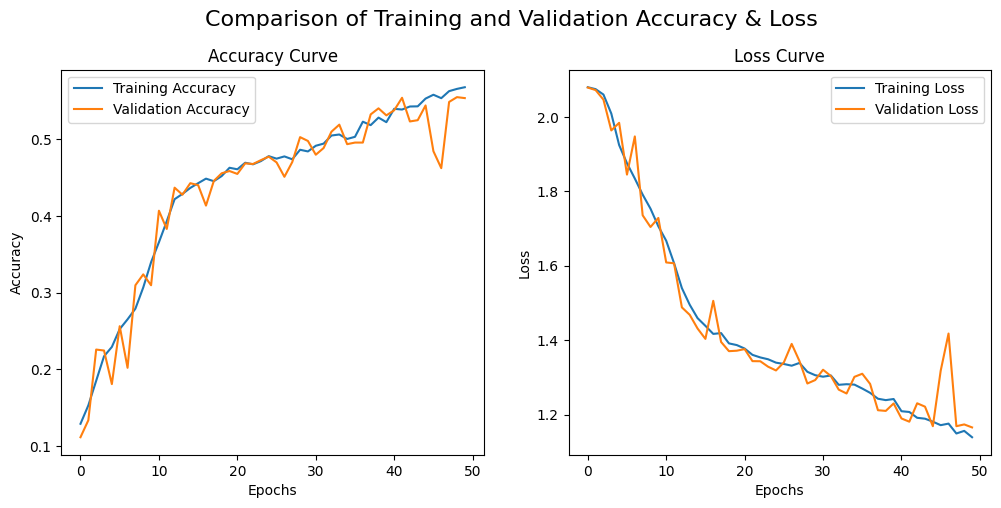

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(history_mod2.history['accuracy'], label='Training Accuracy')
ax1.plot(history_mod2.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title("Accuracy Curve")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend()

# Plot loss
ax2.plot(history_mod2.history['loss'], label='Training Loss')
ax2.plot(history_mod2.history['val_loss'], label='Validation Loss')
ax2.set_title("Loss Curve")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()

fig.suptitle("Comparison of Training and Validation Accuracy & Loss", fontsize=16, y=1.00)

Both training and validation accuracy increase steadily and remain closely aligned throughout the 50 epochs, which implies stable learning. However, **the rate of convergence is slower**, resulting in **a lower final validation accuracy of approximately 0.5533**. This suggests that, while the model is learning effectively without overfitting, it may be limited in its expressive power to extract high-level features.

The overfitting is well addressed, despite having more trainable parameters (100,654), possibily due to the inclusion of 20% dropout after the dense layer. Additionally, this model uses two convolutional layers followed by LSTM layers, unlike P1.1, where each parallel branch contains only one convolutional layer—limiting feature extraction to low-level patterns that may be more prone to noise.

# Problem 2: Achieving Higher Accuracy
This architecture uses both CNN and LSTM, compensating weakness observed in P1.1 and P1.2. Specifically, the CNN is used to extract features from spectrogram images, while the LSTM serves as the classifier. **Two CNN blocks in each parallel** were used because they may better capture mid-level features. Nevertheless, I did not put more than two blocks as it yields lower validation accuracy.

Given overfitting presented in P1 model, several regularisation techniques were used as followed:

* **Dropout**
* **Batch Normalisation**
* **L2 Normalisation**

To enable batch normalisation to function effectively as regularisation, **data augmentation was applied at the initial attempt** to make the dataset independent and identically distributed (i.i.d). Since multiple segments from the same song often appear in a single batch, this may violate i.i.d assumptions. However, the model performed better without augmentation, so it was excluded. Batch normalisation is applied after each convolutional layer and before the activation function. Dropout is also applied at pooling layers, with 0.2 dropout probability during training.

The model begins with a parallel CNN to extract features from 2D Mel spectrograms, which represent time and frequency axes. **Conv2D** kernels are used to capture localised patterns in both time and frequency. After testing both Conv1D and Conv2D under the same architecture, Conv2D consistently yielded better performance. This is possibly because Conv1D requires collapsing one axis, which risks losing important information like pitch changes.

Moreover, Mel spectrograms has relatively large resolution (80×80×1). Therefore, fixed size of kernel may not be fully capture global feature. Therefore, I applied **different kernel sizes (e.g., 3×3 or 5×5) as parallel branch**, which results in different receptive fields. By concatenating the feature maps from both branches before classification, the model can combine features extracted at different scales.

The extracted features are then passed to a **Long Short Term Memory (LSTM)** to capture sequential dependencies in the audio. LSTM are chosen over vanilla RNNs to minimise the vanishing gradient problem in training as well as to improve model's long dependency in a sequence. Also, compared to Gated recurrent unit (GRU), LSTM contain more parameters as there is additional cell states, which may be a possible reason for producing better validation accuracy in this case.

Furthermore, **Adam** is chosen as the optimiser, with following hyperparameters settings: beta_1=0.86, beta_2=0.93, epsilon=1e-5. To mitigate vanishing gradient issues when x<0, **Leaky ReLU** with the slope of 0.3 is adopted as the activation function. Lastly, **I manually designed learning rate Scheduler.** First, the learning rate start with 5e-5 upto first five epochs as the warm-up to prevent overshooting. Instead of using fixed warm-up, I adopt **linear warm-up** (Goyal et al., 2017), where the rate increases linearly to the target rate. Between 5 and 41 epochs, learning rate is set to 0.000555. Between 42 and 46, learning rate is set to 2e-4. Just before training ends (47-50 epochs), I lower the rate to 5e-5.



**[32C5-32C5-P4- LSTM(128)- LSTM(32)] + [32C3-32C3-P2- LSTM(128)- LSTM(32)] → Concatenate → Dense → Output**

- **First Parallel Branch**:
  - 32× Conv2D (5×5 filters)
  - Leaky ReLU (slope = 0.3)
  - MaxPooling2D (4×4)

  - 32× Conv2D (5×5 filters)
  - Leaky ReLU (slope = 0.3)
  - MaxPooling2D (4×4)

- **Second Parallel Branch**:
  - 32× Conv2D (3×3 filters)
  - Leaky ReLU (slope = 0.3)
  - MaxPooling2D (2×2)

  - 32× Conv2D (3×3 filters)
  - Leaky ReLU (slope = 0.3)
  - MaxPooling2D (2×2)

- **Merging Branch**:
  - Concatenate both branches
  - Dense layer for classification (softmax)

**Optimisation Techniques:**
* Batch Normalisation
* Weight initialisation (he normal initialisation)
* Manual design of learning rate

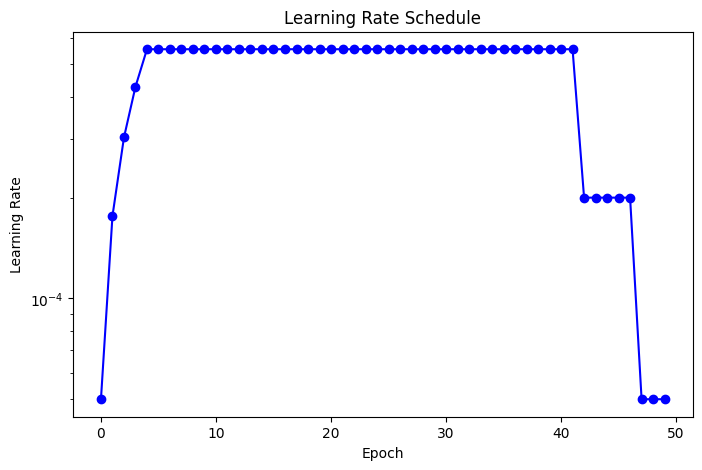

In [ ]:
def scheduler(epoch):
    # Linear warmup from 5e-5 (at epoch 0) to 0.000555 (at epoch 4)
    if epoch <= 4:
        return 5e-5 + (0.000555 - 5e-5) * (epoch / 4)
    elif epoch <= 41:
        return 0.000555
    elif epoch <= 46:
        return 2e-4
    return 5e-5

lrate = LearningRateScheduler(scheduler)

epochs = np.arange(0, 50)
learning_rates = [scheduler(epoch) for epoch in epochs]

# Learning rate schedule plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, learning_rates, marker='o', linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.yscale("log")
plt.show()

In [ ]:
def build_model_opt():
    inputs = Input(shape=n_features)

    # First Parallel Branch
    x = Conv2D(32, (5, 5), padding='same', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=keras.regularizers.l2(0.0001))(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.3)(x)
    x = MaxPooling2D(pool_size=(4, 4))(x)
    x = Dropout(0.2)(x)

    x = Conv2D(32, (5, 5), padding='same', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=keras.regularizers.l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.3)(x)
    x = MaxPooling2D(pool_size=(4, 4))(x)
    x = Dropout(0.2)(x)

    # Reshape to sequence format: (batch, timesteps, features)
    x_shape = x.shape
    x = Reshape((x_shape[1] * x_shape[2], x_shape[3]))(x)
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(32, return_sequences=False)(x)

    # Second Parallel Branch
    y = Conv2D(32, (3, 3), padding='same', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=keras.regularizers.l2(0.0001))(inputs)
    y = BatchNormalization()(y)
    y = LeakyReLU(negative_slope=0.3)(y)
    y = MaxPooling2D(pool_size=(2, 2))(y)
    y = Dropout(0.2)(y)

    y = Conv2D(32, (3, 3), padding='same', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=keras.regularizers.l2(0.0001))(y)
    y = BatchNormalization()(y)
    y = LeakyReLU(negative_slope=0.3)(y)
    y = MaxPooling2D(pool_size=(2, 2))(y)
    y = Dropout(0.2)(y)

    # Reshape to sequence format: (batch, timesteps, features)
    y_shape = y.shape
    y = Reshape((y_shape[1] * y_shape[2], y_shape[3]))(y)
    y = LSTM(128, return_sequences=True)(y)
    y = LSTM(32, return_sequences=False)(y)

    # Merging the Branches
    merged = Concatenate()([x, y])

    # Classification Dense Layer
    outputs = Dense(units=n_classes, activation='softmax')(merged)

    model_opt = Model(inputs=inputs, outputs=outputs)

    model_opt.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000555, beta_1=0.86, beta_2=0.93, epsilon=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    model_opt.summary()
    return model_opt

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 80, 80, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 80, 80, 32)     │            832 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 80, 80, 32)     │            320 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 80, 80, 32)     │            128 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 80, 80, 32)     │            128 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_12            │ (None, 80, 80, 32)     │              0 │ batch_normalization_8… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_14            │ (None, 80, 80, 32)     │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 20, 20, 32)     │              0 │ leaky_re_lu_12[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 40, 40, 32)     │              0 │ leaky_re_lu_14[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 20, 20, 32)     │              0 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 40, 40, 32)     │              0 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 20, 20, 32)     │         25,632 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 40, 40, 32)     │          9,248 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 20, 20, 32)     │            128 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 40, 40, 32)     │            128 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 243,144 (949.78 KB)

 Trainable params: 242,888 (948.78 KB)

 Non-trainable params: 256 (1.00 KB)

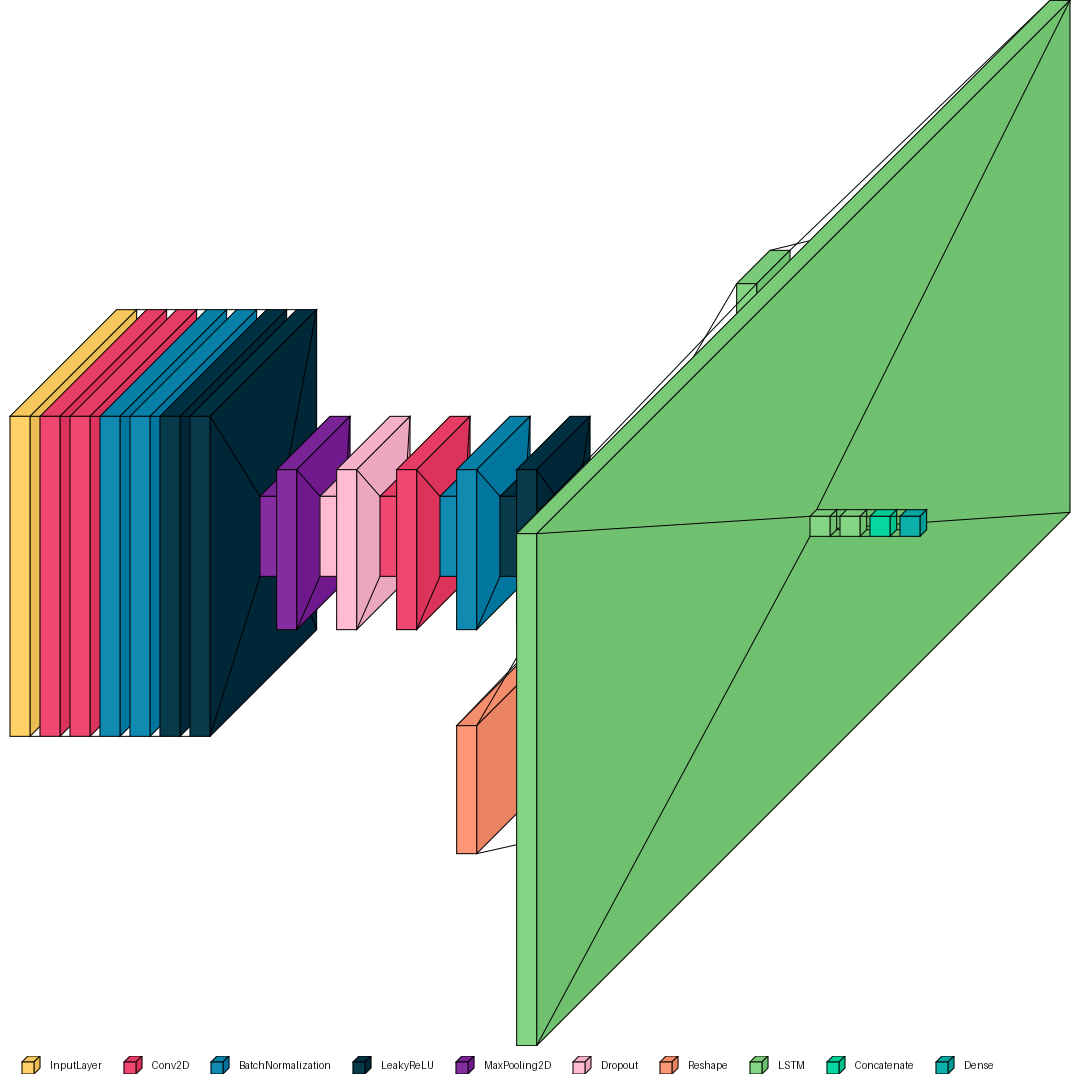

In [ ]:
final_model_opt = build_model_opt()
visualkeras.layered_view(final_model_opt, legend=True)

In [ ]:
# Start training timer
start = time.time()

# Train the model
history_opt = final_model_opt.fit(data_train, label_train, epochs=n_epoch, validation_data=(data_val, label_val), callbacks=[lrate])

# End training timer
end = time.time()

# Calculate and print execution time
time_es = (end - start) / 60
print('Minutes to run: ', time_es)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.3127 - loss: 1.8493 - val_accuracy: 0.1942 - val_loss: 2.1480 - learning_rate: 5.0000e-05
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.5217 - loss: 1.3156 - val_accuracy: 0.5229 - val_loss: 1.3133 - learning_rate: 1.7625e-04
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.6050 - loss: 1.0967 - val_accuracy: 0.6467 - val_loss: 0.9967 - learning_rate: 3.0250e-04
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.6350 - loss: 1.0097 - val_accuracy: 0.6396 - val_loss: 0.9906 - learning_rate: 4.2875e-04
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.6654 - loss: 0.9292 - val_accuracy: 0.6850 - val_loss: 0.8693 - learning_rate: 5.5500e-04
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.7075 - loss: 0.8341 - val_accuracy: 0.7442 - val_loss: 0.7396 - learning_rate: 5.5500e-04
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/ste

Text(0.5, 1.0, 'Comparison of Training and Validation Accuracy & Loss')

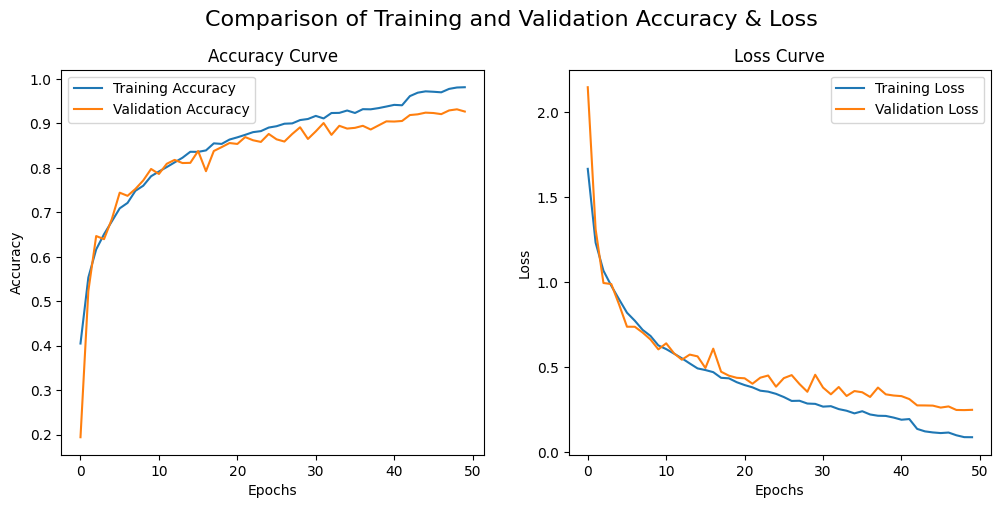

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(history_opt.history['accuracy'], label='Training Accuracy')
ax1.plot(history_opt.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title("Accuracy Curve")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend()

# Plot loss
ax2.plot(history_opt.history['loss'], label='Training Loss')
ax2.plot(history_opt.history['val_loss'], label='Validation Loss')
ax2.set_title("Loss Curve")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()

fig.suptitle("Comparison of Training and Validation Accuracy & Loss", fontsize=16, y=1.00)

The accuracy and loss curves for training and validation closely follow each other, with validation loss consistently decreasing throughout all 50 epochs. Compared to the models in P1.1 and P1.2, this model achieves **the highest validation accuracy (0.9317)** and **lowest validation loss (0.2493)**. Notably, at the very end epoch, thanks to the reduced learning rate of 5e-05, the validation accuracy slightly increases by approximately 0.01 and the validation loss drops by approximately 0.02.  

# Reference

Goyal, P., Dollár, P., Girshick, R., Noordhuis, P., Wesolowski, L., Kyrola, A., Tulloch, A., et al. (2017) “Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour,” arXiv [cs.CV]. Available at: http://arxiv.org/abs/1706.02677.